# Subtask 1
# K-means Clustering

Requirements:

- Python 3.13.1
- numpy
- pandas
- scikit-learn
- matplotlib

In [1]:
import logging
from typing import List, Optional, Dict

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preprocessing
Load the data and preprocess it. Drop features we dont need. Since we are working with mixed-type data, we need to encode features that are not continuous numeric. Also, missing values need to be imputated.

In [2]:
df = pd.read_csv("../dataset/tracks.csv")
df.head()

,id,id_artist,name_artist,full_title,title,featured_artists,primary_artist,language,album,stats_pageviews,...,album_type,disc_number,track_number,duration_ms,explicit,popularity,album_image,id_album,lyrics,modified_popularity
0,TR934808,ART04205421,Rosa Chemical,​polka 2 :-/ by Rosa Chemical (Ft. Ernia & Guè),​polka 2 :-/,"Ernia, Guè",Rosa Chemical,pl,FOREVER AND EVER,196033.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Oplà, ah\nBdope, chiama due b—\n\nMi candidere...",False
1,TR760029,ART04205421,Rosa Chemical,POLKA by Rosa Chemical (Ft. Thelonious B.),POLKA,Thelonious B.,Rosa Chemical,en,FOREVER AND EVER,164450.0,...,album,1.0,3.0,207761.0,True,46.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Greg Willen, non dormire\n(Brr-poh)\n\nT-T-Tro...",False
2,TR916821,ART04205421,Rosa Chemical,​britney ;-) by Rosa Chemical (Ft. MamboLosco ...,​britney ;-),"MamboLosco, RADICAL",Rosa Chemical,en,FOREVER AND EVER,58313.0,...,album,1.0,1.0,193544.0,True,39.0,https://i.scdn.co/image/ab67616d0000b2736d5e14...,ALB115557,"Mothz\nYeah, yeah, yeah-yeah\nBdope, chiama du...",False
3,TR480968,ART04205421,Rosa Chemical,CEO by Rosa Chemical (Ft. Taxi B),CEO,Taxi B,Rosa Chemical,it,OKAY OKAY !! - EP,39890.0,...,single,1.0,2.0,169000.0,True,47.0,https://i.scdn.co/image/ab67616d0000b27367c03d...,ALB730959,Designer sui vestiti penso di essere un outlet...,False
4,TR585039,ART04205421,Rosa Chemical,LONDRA by Rosa Chemical (Ft. Rkomi),LONDRA,Rkomi,Rosa Chemical,en,FOREVER AND EVER,35432.0,...,album,1.0,8.0,194779.0,True,41.0,https://i.scdn.co/image/ab67616d0000b273fcdb60...,ALB436151,"Bdope (Yeah)\n\nVuole solo me, non fare la gel...",False


### Drop Irrelevant Features
Many columns such as names or unique identifiers are not relevant for clustering. We drop them.

In [3]:
drop_cols = [
    "id",
    "id_artist",
    "name_artist",
    "full_title",
    "title",
    "swear_IT_words",
    "swear_EN_words",
    "album_name",
    "album_release_date",
    "id_album",
    "album_image",
    "lyrics",
    "month",
    "day",
    "disc_number",
    "track_number",
    "album_type",
    "popularity",
    "year",
    "primary_artist",
    "featured_artists",
    "album",
]

df = df.drop(columns=drop_cols)
df.head()

,language,stats_pageviews,swear_IT,swear_EN,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,...,flux,rms,zcr,flatness,spectral_complexity,pitch,loudness,duration_ms,explicit,modified_popularity
0,pl,196033.0,13,6,102.0,911.0,8.931373,4.170455,0.575284,8.133929,...,1.4499,0.1786,0.1046,0.8202,25.7148,2311.1779,17.8675,207761.0,True,False
1,en,164450.0,9,12,56.0,675.0,12.053571,4.280851,0.648936,12.500000,...,1.3533,0.2020,0.1175,0.6739,29.1089,1892.1924,21.4595,207761.0,True,False
2,en,58313.0,16,12,88.0,758.0,8.613636,4.075251,0.556856,8.422222,...,1.3822,0.2552,0.0800,0.7842,26.9762,2484.3503,29.4590,193544.0,True,False
3,it,39890.0,8,3,37.0,382.0,10.324324,4.023881,0.534328,6.701754,...,1.5499,0.1971,0.0436,0.8764,14.2956,2984.6109,20.5067,169000.0,True,False
4,en,35432.0,1,0,48.0,429.0,8.937500,3.922857,0.491429,8.411765,...,1.0886,0.2369,0.0695,0.8571,36.6951,1572.0499,25.3407,194779.0,True,False


In [4]:
def scale_cols(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if num_cols:
        df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    if bool_cols:
        df[bool_cols] = df[bool_cols].apply(LabelEncoder().fit_transform)
    return df


def imputate_na(
    df: pd.DataFrame,
    num_cols: Optional[List[str]],
    cat_cols: Optional[List[str]],
    bool_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    if num_cols:
        # imputate numeric features
        for col in num_cols:
            # For integer columns we need to round the median
            if is_integer_dtype(df[col]):
                df[col] = df[col].fillna(round(df[col].median()))
            else:
                df[col] = df[col].fillna(df[col].median())
    if cat_cols is None:
        cat_cols = []
    if bool_cols is None:
        bool_cols = []
    # add "missing" category for categorical features
    for col in cat_cols + bool_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].fillna("<NA>")
    return df


### Cleaning, Imputating, Scaling and Labelling
Now execute the functions from above to return a dataframe we can use for computation.

In [5]:
# Save old dataframe for later
og_df = df.copy(deep=True)

cat_cols = [
    "language",
]
bool_cols = ["explicit"]
num_cols = [
    "stats_pageviews",
    "n_sentences",
    "n_tokens",
    "swear_IT",
    "swear_EN",
    "tokens_per_sent",
    "char_per_tok",
    "lexical_density",
    "avg_token_per_clause",
    "bpm",
    "centroid",
    "rolloff",
    "flux",
    "rms",
    "zcr",
    "flatness",
    "spectral_complexity",
    "pitch",
    "loudness",
    "duration_ms",
    "modified_popularity",
]

# Check we registered all columns
assert set(cat_cols + bool_cols + num_cols) == set(df.columns)

df = imputate_na(df, num_cols, cat_cols, bool_cols)
df = scale_cols(df, num_cols, cat_cols, bool_cols)

df.head()

,language,stats_pageviews,swear_IT,swear_EN,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,...,flux,rms,zcr,flatness,spectral_complexity,pitch,loudness,duration_ms,explicit,modified_popularity
0,24,4.382689,2.876641,2.069739,1.730216,1.986653,0.046153,0.261733,0.992899,0.009660,...,1.397106,-0.704880,2.303956,-0.366859,-0.201378,0.144963,-0.737737,0.048662,1,-0.083873
1,9,3.566034,1.796922,4.417792,-0.137659,0.854572,0.598164,0.510133,2.193008,0.310191,...,0.690571,-0.341557,3.023822,-1.711511,0.201867,-0.954671,-0.321208,0.048662,1,-0.083873
2,9,0.821605,3.686431,4.417792,1.161733,1.252719,-0.010024,0.047518,0.692629,0.029505,...,0.901946,0.484459,0.931189,-0.697737,-0.051514,0.599457,0.606418,-0.112995,1,-0.083873
3,17,0.345234,1.526992,0.895713,-0.909173,-0.550936,0.292429,-0.068068,0.325553,-0.088921,...,2.128509,-0.417637,-1.100060,0.149679,-1.558063,1.912399,-0.431695,-0.392077,1,-0.083873
4,9,0.229961,-0.362517,-0.278313,-0.462507,-0.325479,0.047236,-0.295378,-0.373469,0.028785,...,-1.245453,0.200322,0.345252,-0.027709,1.103163,-1.794890,0.128858,-0.098952,1,-0.083873


### Encoding
Now we use one-hot encoding to encode the categorical features. Boolean features only need encoding if they contain NaN or NA values (=missing values), otherwise they are left as is. To reduce the number of features, we only encode features that have more unique values than a threshhold. This will get rid of features with too many unique values, such as song lyrics. These features would add up to N new features to the dataset, which is not a good idea.

In [6]:
def one_hot_encode_feature(df: pd.DataFrame, feature_to_encode: str, weight: float = 1) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature_to_encode], dtype="int32", prefix=feature_to_encode)
    dummies *= weight
    result_df = pd.concat([df, dummies], axis=1)
    return result_df.drop(columns=feature_to_encode)


encoded_df = df.copy(deep=True)

for col in cat_cols + [col for col in bool_cols if encoded_df[col].nunique() > 2]:
    # Dont encode columns with too many unique values
    if encoded_df[col].nunique() > 50:
        logging.warning("Column %s has too many unique values, dropping", col)
        encoded_df = encoded_df.drop(columns=col)
    else:
        encoded_df = one_hot_encode_feature(encoded_df, col)

encoded_df.head()

,stats_pageviews,swear_IT,swear_EN,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,bpm,...,language_29,language_30,language_31,language_32,language_33,language_34,language_35,explicit_0,explicit_1,explicit_2
0,4.382689,2.876641,2.069739,1.730216,1.986653,0.046153,0.261733,0.992899,0.009660,0.793373,...,0,0,0,0,0,0,0,0,1,0
1,3.566034,1.796922,4.417792,-0.137659,0.854572,0.598164,0.510133,2.193008,0.310191,0.570979,...,0,0,0,0,0,0,0,0,1,0
2,0.821605,3.686431,4.417792,1.161733,1.252719,-0.010024,0.047518,0.692629,0.029505,0.732074,...,0,0,0,0,0,0,0,0,1,0
3,0.345234,1.526992,0.895713,-0.909173,-0.550936,0.292429,-0.068068,0.325553,-0.088921,1.798815,...,0,0,0,0,0,0,0,0,1,0
4,0.229961,-0.362517,-0.278313,-0.462507,-0.325479,0.047236,-0.295378,-0.373469,0.028785,-0.307382,...,0,0,0,0,0,0,0,0,1,0


## Clustering
We can now cluster the songs using K-means clustering. The most important objective is finding a suitable number of clusters k. The clustering is run 9 times, with k values from 2 to 10. Each time, the result is evaluated using four different metrics:
### Sum of Squared Errors (SSE)
Sum of squared errors (SSE) is the sum of squared distances between each data point and its assigned centroid. Lower SSE means better clustering results. This is the cost function of k-means, but its still a useful tool to evaluate the result post-clustering. It is also called inertia.
### Silhouette
Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A higher silhouette score means better clustering results.
### Variance Ratio Criterion
Variance ratio criterion is a measure of the ratio of the within-cluster variance to the between-cluster variance. A higher variance ratio means better clustering results.
### Davies-Bouldin Index
Davies-Bouldin index is a measure of the average similarity between clusters, where similarity is defined as the ratio of the within-cluster distance to the between-cluster distance. A lower Davies-Bouldin index means better clustering results.

<br>
K-means is run 100 times (for each k) and inertia is used to determine the best result of the 100 runs. K-means++ is used to initialize the clusters. Four plots are created that show the metrics results for each value of k.

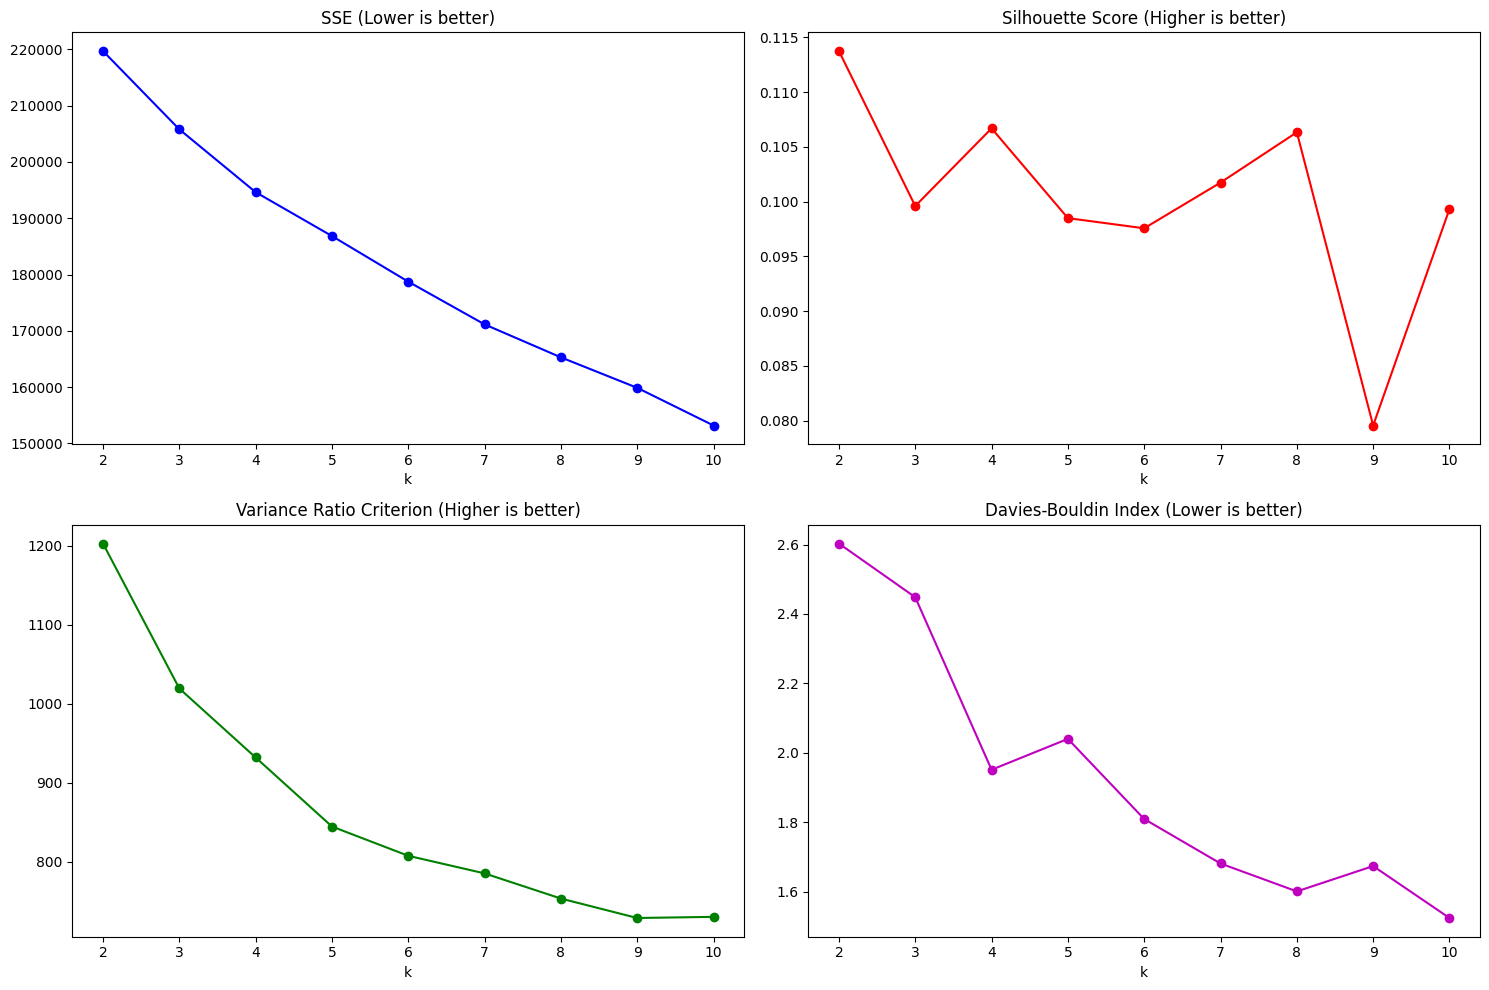

In [7]:
metrics = {
    'sse': [], # Sum of Squared Errors
    'silhouette': [],
    'vrc': [], # Variance Ratio Criterion; Calinski, Harabasz
    'davies_bouldin': []
}
results = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100)
    labels = kmeans.fit_predict(encoded_df)
    results[k] = labels

    metrics['sse'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(encoded_df.values, labels))
    metrics['vrc'].append(calinski_harabasz_score(encoded_df.values, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(encoded_df.values, labels))

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
k_range = range(2, 11)

axes[0,0].plot(k_range, metrics['sse'], 'bo-')
axes[0,0].set_title('SSE (Lower is better)')
axes[0,0].set_xlabel('k')

axes[0,1].plot(k_range, metrics['silhouette'], 'ro-')
axes[0,1].set_title('Silhouette Score (Higher is better)')
axes[0,1].set_xlabel('k')

axes[1,0].plot(k_range, metrics['vrc'], 'go-')
axes[1,0].set_title('Variance Ratio Criterion (Higher is better)')
axes[1,0].set_xlabel('k')

axes[1,1].plot(k_range, metrics['davies_bouldin'], 'mo-')
axes[1,1].set_title('Davies-Bouldin Index (Lower is better)')
axes[1,1].set_xlabel('k')

plt.tight_layout()
plt.show()

## Evaluation
### Cluster Overview
What do we do with the clusters now? What we can do is to look into each cluster and look into the average variables that it has. We create a table that has a row for each cluster and a column for each variable. The value in the cell is the rounded average of that variable for that cluster. In case of categorical variables, the most common category is listed with its percentage in braces. For boolean variables, both options are listed with their percentages. The columns (features) are sorted by their importance towards the clustering process, more on that in the next section.

In [8]:
def cluster_overview(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    num_cols: List[str],
    cat_cols: List[str],
    bool_cols: List[str],
    feature_importances: Dict[str, float],
) -> pd.DataFrame:
    def num_agg(series):
        res = f"~{series.mean():.2f}"
        if res == "~-0.0":
            return "~0.0"
        return res

    def cat_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) >= 1:
            return f"{vc.index[0]} ({vc.iloc[0]:.0%})"
        else:
            return "NA (100%)"

    def bool_agg(series):
        vc = series.value_counts(normalize=True)
        if len(vc) == 1:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}"
        elif len(vc) == 2:
            return f"{vc.iloc[0]:.0%} {vc.index[0]}/{vc.iloc[1]:.0%} {vc.index[1]}"
        else:
            return "100% NA"

    df = original_df.copy(deep=True)
    df["Cluster ID"] = cluster_labels
    
    # Calculate per-cluster aggregations
    df_clusters = pd.concat(
        [
            df[num_cols + ["Cluster ID"]].groupby("Cluster ID").agg(num_agg) if num_cols else pd.DataFrame(),
            df[cat_cols + ["Cluster ID"]].groupby("Cluster ID").agg(cat_agg) if cat_cols else pd.DataFrame(),
            df[bool_cols + ["Cluster ID"]].groupby("Cluster ID").agg(bool_agg) if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_clusters = df_clusters.reset_index()
    
    # Calculate overall aggregations for entire dataset
    df_overall = pd.concat(
        [
            df[num_cols].agg(num_agg).to_frame().T if num_cols else pd.DataFrame(),
            df[cat_cols].agg(cat_agg).to_frame().T if cat_cols else pd.DataFrame(),
            df[bool_cols].agg(bool_agg).to_frame().T if bool_cols else pd.DataFrame(),
        ],
        axis=1,
    )
    df_overall["Cluster ID"] = "All Clusters"
    
    # Add member counts
    counts = np.bincount(cluster_labels)
    df_clusters["Members"] = df_clusters.apply(lambda row: counts[int(row["Cluster ID"])], axis=1)
    df_overall["Members"] = len(cluster_labels)
    
    # Format cluster IDs
    df_clusters["Cluster ID"] = df_clusters["Cluster ID"].apply(lambda x: f"Cluster {x}")
    
    # Combine cluster data with overall data
    df_result = pd.concat([df_clusters, df_overall], ignore_index=True)
    
    # Order features by importance
    df_result = df_result[["Cluster ID", "Members"] + list(feature_importances.keys())]

    return df_result


def feature_importances(
    df: pd.DataFrame,
    labels: np.ndarray
) -> Dict[str, float]:
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(df, labels)
    return dict(
        sorted(
            zip(df.columns, classifier.feature_importances_),
            key=lambda it: it[1],
            reverse=True,
        )
    )



chosen_k = 6
labels = results[chosen_k]

feature_importances_dict = feature_importances(df, labels)
cluster_overview(og_df, labels, num_cols, cat_cols, bool_cols, feature_importances_dict)

,Cluster ID,Members,zcr,loudness,rms,rolloff,n_tokens,centroid,n_sentences,spectral_complexity,...,tokens_per_sent,avg_token_per_clause,char_per_tok,lexical_density,bpm,explicit,stats_pageviews,swear_EN,modified_popularity,language
0,Cluster 0,14,~0.06,~26.07,~0.24,~1522.32,~427.71,~0.13,~60.36,~26.55,...,~9.12,~358.11,~3.80,~0.56,~127.11,64% True/36% False,~15030.00,~2.57,~0.00,en (54%)
1,Cluster 1,2983,~0.08,~24.78,~0.23,~2250.54,~481.40,~0.17,~57.82,~33.21,...,~8.80,~7.56,~4.02,~0.51,~112.68,51% False/49% True,~25700.64,~0.56,~0.00,it (84%)
2,Cluster 2,3869,~0.05,~30.05,~0.27,~1278.08,~464.59,~0.13,~55.72,~28.65,...,~8.66,~7.60,~4.02,~0.52,~116.83,52% True/48% False,~39418.67,~0.54,~0.00,it (86%)
3,Cluster 3,2314,~0.05,~14.29,~0.15,~1349.72,~369.97,~0.11,~44.95,~18.63,...,~8.50,~7.37,~4.19,~0.51,~114.96,60% False/40% True,~27713.28,~0.31,~0.00,it (87%)
4,Cluster 4,1908,~0.06,~23.96,~0.22,~1635.96,~740.83,~0.14,~86.83,~26.70,...,~8.71,~7.71,~4.02,~0.51,~110.22,64% True/36% False,~50138.62,~1.80,~0.00,it (80%)
5,Cluster 5,78,~0.06,~18.34,~0.18,~1452.63,~526.00,~0.13,~61.00,~22.60,...,~8.49,~5.66,~4.04,~0.48,~106.45,100% NA,~40375.00,~0.06,~1.00,it (92%)
6,All Clusters,11166,~0.06,~24.23,~0.22,~1616.97,~496.89,~0.14,~59.40,~27.41,...,~8.67,~8.00,~4.05,~0.51,~114.13,51% True/49% False,~36993.65,~0.71,~0.01,it (85%)


### Feature Importances
The feature importance was already used above to sort the columns of the cluster overview table descending by their importance towards the clustering process. We can also plot it as a bar chart to get a better undestanding of the feature that contributed most to the separation of the clusters. 

<br>
We cannot directly extract the feature importance from the k-means model, but instead we can approximate the feature importances by training a supervised model on the cluster labels we generated with k-means. Some sort of decision tree models works well because of their explainability, which allows us to calculate the feature importances. We use a Random Forest Classifier here.

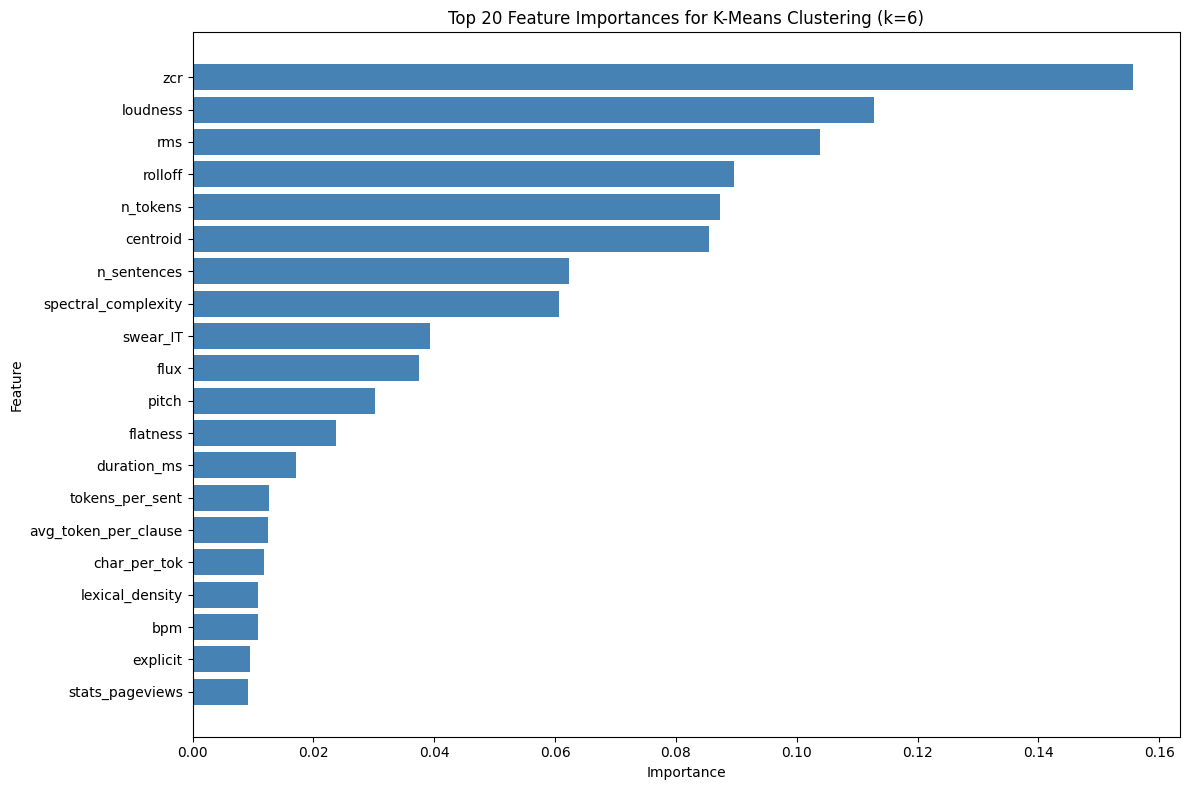

In [9]:
top_n = 20
top_features = list(feature_importances_dict.items())[:top_n]
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
plt.barh(range(len(features)), importances, color='steelblue')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances for K-Means Clustering (k={chosen_k})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Artists per Cluster
To validate whether the clustering makes sense, we can examine which artists belong to each cluster. This allows us to listen to the artists and verify if the clusters have meaningful musical or stylistic coherence.

In [10]:
def get_artists_per_cluster(
    original_df: pd.DataFrame,
    cluster_labels: np.ndarray,
    artist_column: str = 'name_artist',
    top_n: int = 10
) -> pd.DataFrame:
    original_df['cluster'] = cluster_labels
    
    cluster_data = {}
    for cluster_id in sorted(np.unique(cluster_labels)):
        cluster_df = original_df[original_df['cluster'] == cluster_id]
        
        # Count tracks per artist in this cluster
        artist_counts = cluster_df[artist_column].value_counts().head(top_n)
        
        # Format as "Artist (N tracks)"
        formatted_artists = [f"{artist} ({count})" for artist, count in zip(artist_counts.index, artist_counts.values)]
        
        # Pad with empty strings if less than top_n artists
        while len(formatted_artists) < top_n:
            formatted_artists.append("")
        
        cluster_data[f'Cluster {cluster_id}'] = formatted_artists
    
    df = pd.DataFrame(cluster_data)
    return df


full_og_df = pd.read_csv('../dataset/tracks.csv')
artists_df = get_artists_per_cluster(full_og_df, labels, top_n=10)
artists_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,M¥SS KETA (4),Caneda (95),Guè (144),Mondo Marcio (89),Mondo Marcio (128),Frankie hi-nrg mc (73)
1,Rose Villain (2),Emis Killa (93),Gemitaiz (137),Ghemon (86),Bassi Maestro (112),Club Dogo (1)
2,Shade (2),Mondo Marcio (89),Emis Killa (93),Bassi Maestro (76),Fabri Fibra (102),Rocco Hunt (1)
3,Roshelle (1),Guè (88),Tony Boy (85),Neffa (75),Vacca (89),Ghemon (1)
4,Noyz Narcos (1),Gemitaiz (84),Sfera Ebbasta (84),Dargen D’Amico (65),Gemitaiz (66),Entics (1)
5,Shablo (1),J-Ax (82),Lazza (82),Skioffi (62),Guè (60),Sottotono (1)
6,MadMan (1),Vacca (75),Marracash (79),Caparezza (61),Club Dogo (56),
7,Achille Lauro (1),Fabri Fibra (71),Vacca (78),Articolo 31 (55),Rancore (53),
8,Caneda (1),Achille Lauro (70),Shiva (76),Coez (52),MadMan (51),
9,,Fedez (70),Salmo (73),Achille Lauro (50),Inoki (51),


### 3D PCA Visualization
To visualize the clustering results in 3D space, we use Principal Component Analysis (PCA) to reduce the high-dimensional feature space to 3 components. This allows us to see how well the clusters are separated in a lower-dimensional representation.

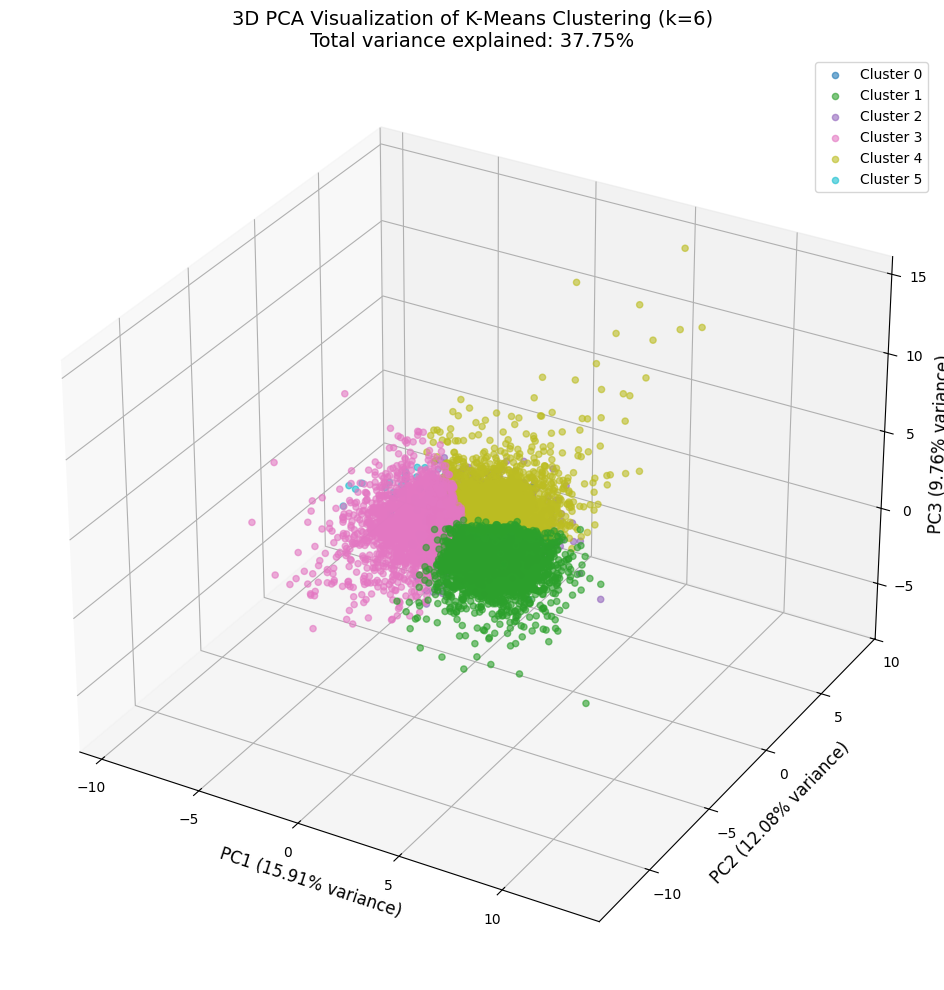

Explained variance by component: [0.15905324 0.1208445  0.09757981]
Total explained variance: 37.75%


In [11]:
# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
pca_features = pca.fit_transform(encoded_df)

# Create 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, chosen_k))

# Plot each cluster with a different color
for cluster_id in range(chosen_k):
    cluster_mask = labels == cluster_id
    ax.scatter(
        pca_features[cluster_mask, 0],
        pca_features[cluster_mask, 1],
        pca_features[cluster_mask, 2],
        c=[colors[cluster_id]],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=20
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)', fontsize=12)
ax.set_title(f'3D PCA Visualization of K-Means Clustering (k={chosen_k})\nTotal variance explained: {pca.explained_variance_ratio_.sum():.2%}', fontsize=14)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Explained variance by component: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")